# Quick Overview

This notebook provides a quick example of how to start using the `spectral_recovery` package. More detailed examples will soon become available in the [User Guide](https://people-er.github.io/Spectral-Recovery/about/).

If you want to try out the tool on your own, you can use the [test data on GitHub](https://github.com/PEOPLE-ER/Spectral-Recovery/tree/main/docs/test_data/test_data.zip).

Once the tool is installed with `pip install spectral-recovery`, you can import the package

In [1]:
import spectral_recovery as sr

## Defining a RestorationArea

To begin, we must create a `RestorationArea` object. This object holds and coordinates all the information necessary to compute recovery metrics for an area that has experienced disturbance and/or restoration. The following section briefly describes the input parameters but for more in-depth information, please see the [Spectral Recovery Tool](https://people-er.github.io/Spectral-Recovery/about/#2-the-spectral-recovery-tool) section in the User Guide.

### Input Parameters

| Name  | Type  | Description  |
|---|:---:|---|
| **restoration_polygon**  | geopandas.GeoDataFrame  | The spatial deliniation of the restoration event, i.e where disturance/restoration has occured.  |   
|  **restoration_start** | datetime | The year the disturbance began.  |   
| **disturbance_start**  | datetime  |  The year the restoration event began. |  
|  **reference_polygon** | geopandas.GeoDataFrame  | The spatial deliniation of the reference systems.  |   
|  **reference_years** | list of datetime  | The year or range of years to use for determining a recovery target.  |   
|  **composite_stack** | xarray.DataArray  | The timeseries of annual composites for computing recovery metrics.   |  

### Prepping Inputs

#### Annual Composites

Next, read in your set of annual composites. To do this use the `read_and_stack_tifs` method. The method requires that you either provide a path to a directory containing all of your annual composites, or you provide a list of paths to each individual composite. Each composite:

1. _must_ be named after the year of which they are a composite, e.g for a composite of 2014 the file must be named `2014.tif`
2. _must_ have the bands named by their common names/acronyms

Each composite can contain multiple bands but each band must be present in all composites. You must also provide the Platform(s) from which the composite is derived.

| Parameter   | Options   |
|:---:|---|
|  Platform   | 'landsat_oli', 'landsat_etm', 'landsat_tm','sentinel_2' |

The set of annual composites that we'll be using in this notebook was created using the [GEE BAP tool](https://github.com/saveriofrancini/bap).

In [2]:
composite_stack = sr.read_and_stack_tifs(
    "test_data/annual_composites/landsat",
    platform=["landsat_tm", "landsat_etm", "landsat_oli"],
    band_names={1: "blue", 2: "green", 3: "red", 4: "nir", 5: "swir1", 6: "swir2"},
    array_type="numpy"
)

Compute your indices using the `compute_indices` function. The function takes 2 parameters 1) your image stack, 2) choice of indices.

| Parameter   | Options   |
|:---:|---|
|  Indices   | 'NDVI', 'NBR','GNDVI', 'EVI', 'AVI', 'SAVI','NDWI','TCG','TCW','TCB','SR','NDMI','GCI','NDII'  |


In [3]:
indices_stack = sr.compute_indices(
    image_stack=composite_stack, 
    indices=["NBR", "NDMI", "GNDVI"]
)

#### Polygons

Read you restoration polygon using GeoPandas

Text(0.5, 1.0, 'Test restoration polygon')

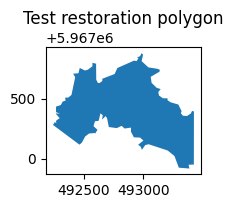

In [4]:
import geopandas as gpd

restoration_poly = gpd.read_file("test_data/wildfire_516.gpkg")
restoration_poly.plot(figsize=(2, 2)).set_title("Test restoration polygon")

#### Dates/Years

Finally, define the years we need for a restoration area: disturbance event start year, restoration event start year, and reference year(s).

In [5]:
disturbance_start = "2005" # the start of the disturbance window
restoration_start ="2006" # the start of the restoration window
reference_years = ["2003", "2004"] # derive recovery target from the range of these years

### Creating a RestorationArea

Now that we've prepped our input, we can create a RestorationArea and are one step closer to computing recovery metrics.

In [6]:
ra = sr.RestorationArea(
    restoration_polygon=restoration_poly,
    disturbance_start=disturbance_start, 
    restoration_start=restoration_start,
    reference_years=reference_years,
    composite_stack=indices_stack,
)
# ta-da! 

You can visualize the spectral trajectory of your RestorationArea using the `plot_spectral_trajectory` function. If you want to write the plot to file, pass your desired path to the function.

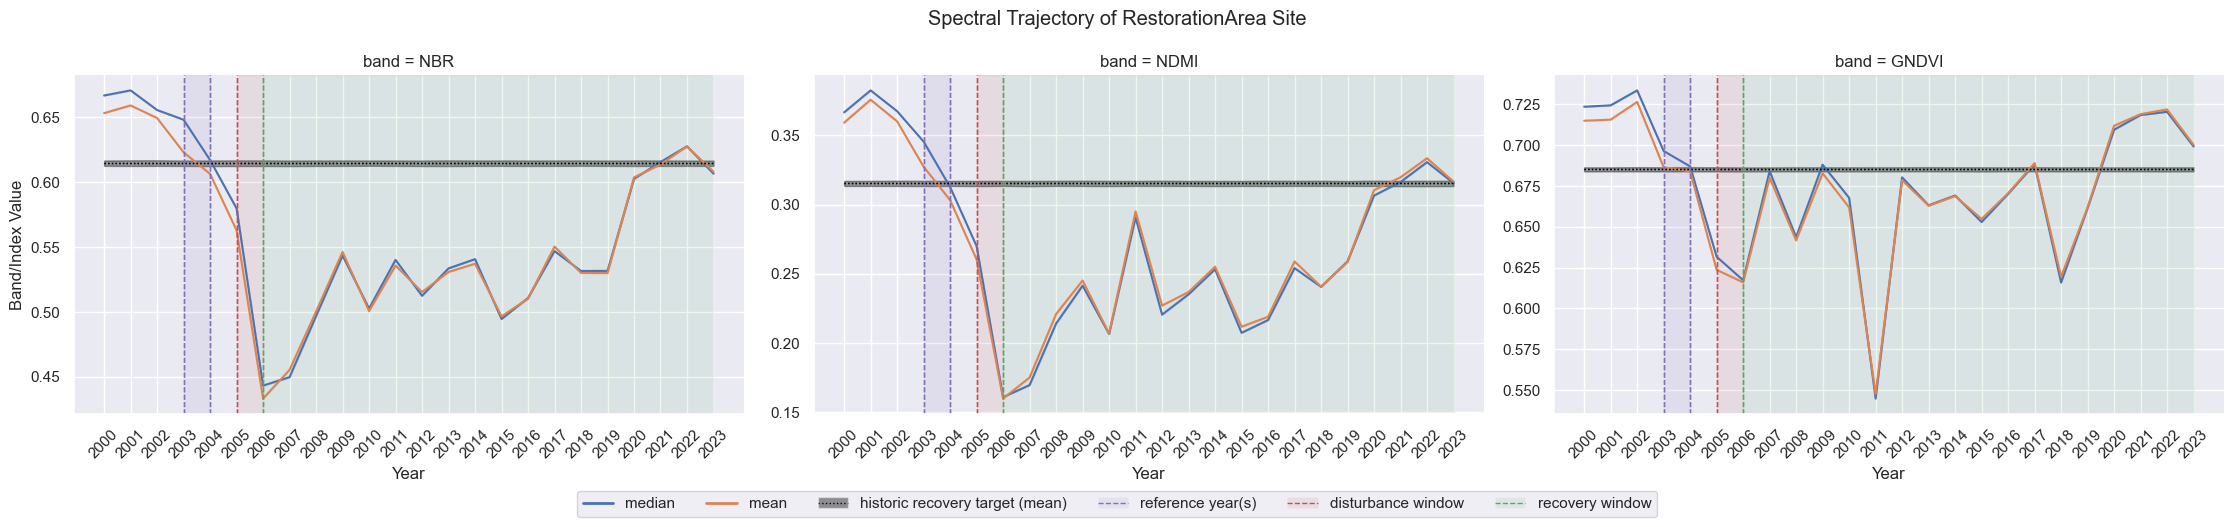

In [7]:
ra.plot_spectral_trajectory()

## Computing Recovery Metrics

In [8]:
import matplotlib.pyplot as plt

def plot_metrics(metric):
    """ Plot the three bands in a single figure. """
    fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[15, 4])
    for i in range(3):
        metric[0,i,:,:].plot(ax=axes[i])
        axes[i].set_title(f"{str(metric.metric.values[0])}: {metric['band'].values[i]}")
        axes[i].set_xlabel("X coordinate")
        if i == 0:
            axes[i].set_ylabel("Y coordinate")
        else:
            axes[i].set_ylabel("")
        plt.tight_layout()


Now that we have our RestorationArea defined, computing recovery metrics is as simple as calling the desired metric method!

### Y2R

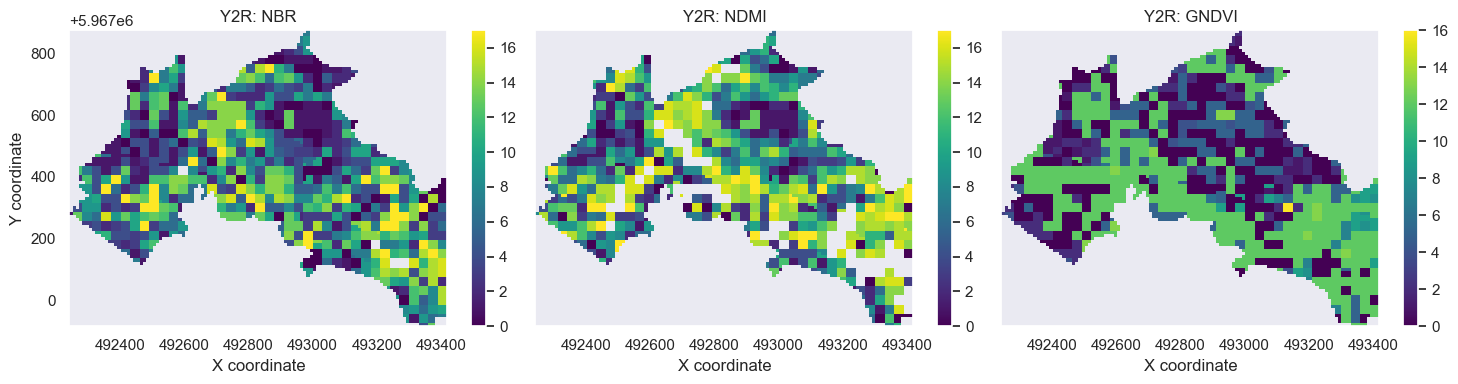

In [9]:
y2r = ra.y2r()
plot_metrics(y2r)

### R80P

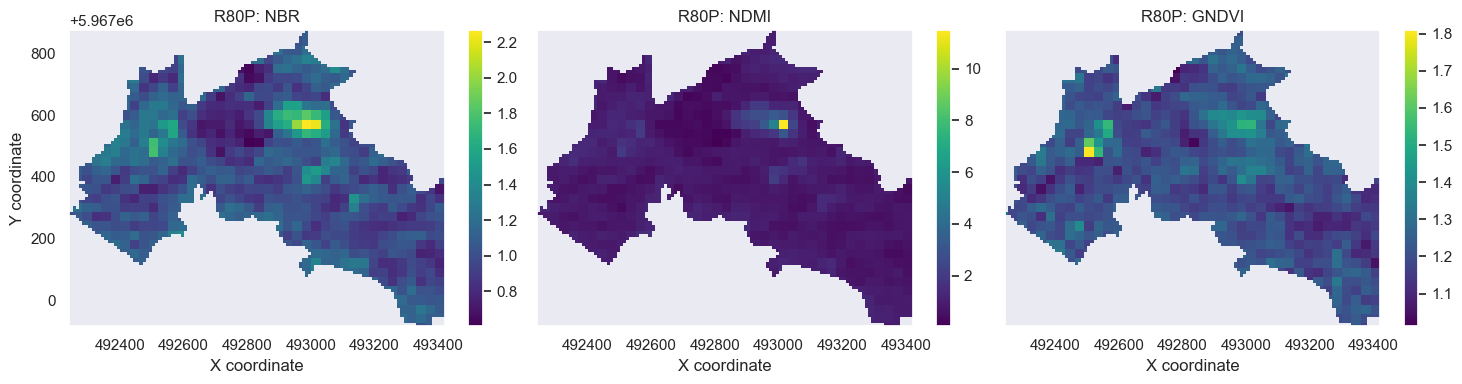

In [10]:
r80p = ra.r80p(timestep=4)
plot_metrics(r80p)

### YrYr

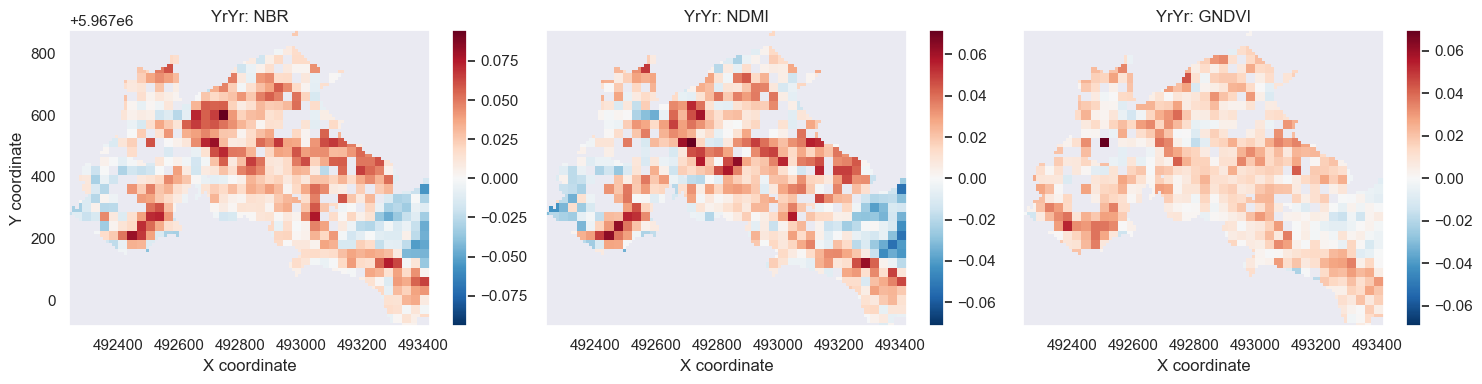

In [11]:
yryr = ra.yryr(timestep=4)
plot_metrics(yryr)

### dNBR

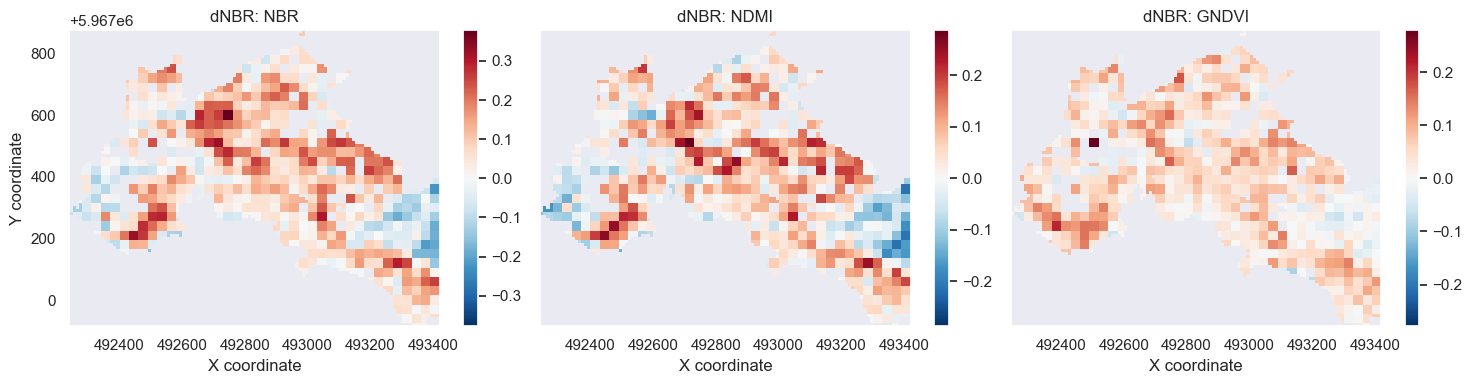

In [12]:
dNBR = ra.dnbr(timestep=4)
plot_metrics(dNBR)

###  Writing Results

To write your metric results to raster files, the simpliest way is to use `rioxarray`'s `to_raster` function:


In [ ]:
y2r[0,:,:,:].rio.to_raster("./y2r.tif")